# Tutorial 4: Human PBMC (ATAC + RNA + Protein Epitopes)

Welcome to this tutorial on using the `mTopic` package for multimodal topic modeling of human peripheral blood mononuclear cells (PBMC), using the [DOGMA-seq](https://www.nature.com/articles/s41587-021-00927-2) dataset. We use a publicly available dataset from [GEO](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE166188), which includes ATAC, RNA, and protein epitope measurements.

Let’s begin by importing the required libraries and downloading the filtered training data, available at [Zenodo](https://doi.org/10.5281/zenodo.15471869).

In [1]:
import mtopic

! wget -O Human_PBMC_ATAC_RNA_Protein_filtered.h5mu \
  "https://zenodo.org/records/15471869/files/Human_PBMC_ATAC_RNA_Protein_filtered.h5mu?download=1"

--2025-05-20 17:21:18--  https://zenodo.org/records/15471869/files/Human_PBMC_ATAC_RNA_Protein_filtered.h5mu?download=1
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.45.92, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 71174260 (68M) [application/octet-stream]
Saving to: ‘Human_PBMC_ATAC_RNA_Protein_filtered.h5mu’

Human_PBMC_ATAC_RNA 100%[===================>]  67.88M  18.5MB/s    in 3.7s    

2025-05-20 17:21:22 (18.5 MB/s) - ‘Human_PBMC_ATAC_RNA_Protein_filtered.h5mu’ saved [71174260/71174260]



## Non-Spatial Multimodal Topic Modeling

The filtered dataset contains 7,349 cells and includes three modalities:

- `atac`: chromatin accessibility data,
- `rna`: gene expression data,
- `prot`: protein epitope data.

This rich multimodal structure enables a joint modeling of transcriptional activity, regulatory accessibility, and protein epitope expression at single-cell resolution.

In [2]:
pbmc = mtopic.read.h5mu('Human_PBMC_ATAC_RNA_Protein_filtered.h5mu')

pbmc

MuData object with n_obs × n_vars = 7349 × 147123
  obs:	'celltype', 'celltype_coarse'
  3 modalities
    atac:	7349 x 136915
      obs:	'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'ReadsInPeaks', 'FRIP', 'n_counts'
      var:	'n_cells'
    rna:	7349 x 10000
      obs:	'n_counts', 'n_genes'
      var:	'feature_type', 'genome', 'id', 'interval', 'name'
    prot:	7349 x 208
      obs:	'n_counts'

To prepare the dataset for topic modeling (as in Tutorials 2 and 3), we need to transform and scale the raw counts across all modalities:

- **TF-IDF transformation** (`mtopic.pp.tfidf`) for `atac` and `rna`:  
  Emphasizes informative, modality-specific features by balancing frequency and importance.

- **CLR normalization** (`mtopic.pp.clr`) for `prot`:  
  Corrects compositional bias in protein counts across cells.

After normalization, apply `mtopic.pp.scale_counts` to scale total counts across modalities, ensuring balanced contribution to the topic model.

In [3]:
mtopic.pp.tfidf(pbmc, mod='atac')
mtopic.pp.tfidf(pbmc, mod='rna')
mtopic.pp.clr(pbmc, mod='prot')
mtopic.pp.scale_counts(pbmc)

To train a non-spatial topic model using `mtopic.tl.MTM`, define the model, run variational inference (`VI`) for 500 iterations, and export the trained parameters to the `pbmc` object. While we use 500 iterations in this tutorial for thorough training, the model often converges to meaningful topics in as few as 20 iterations. You can adjust the number of iterations based on dataset size and desired precision.

In [4]:
MTM = mtopic.tl.MTM(pbmc, n_topics=30, n_jobs=100)
MTM.VI(n_iter=500)
mtopic.tl.export_params(MTM, pbmc)

pbmc

100%|███████████████████████████████████████| 500/500 [1:41:26<00:00, 12.17s/it]


MuData object with n_obs × n_vars = 7349 × 147123
  obs:	'celltype', 'celltype_coarse'
  obsm:	'topics'
  3 modalities
    atac:	7349 x 136915
      obs:	'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'ReadsInPeaks', 'FRIP', 'n_counts'
      var:	'n_cells'
      varm:	'signatures'
    rna:	7349 x 10000
      obs:	'n_counts', 'n_genes'
      var:	'feature_type', 'genome', 'id', 'interval', 'name'
      varm:	'signatures'
    prot:	7349 x 208
      obs:	'n_counts'
      varm:	'signatures'

## Visualizing PBMC Results

To visualize the MTM results, compute a 2-dimensional UMAP embedding based on the topic-cell distributions using the `mtopic.tl.umap` function. This projects cells into a low-dimensional space that preserves topic-driven structure.

The resulting embedding is saved in `pbmc.obsm['umap']` and can be used for visualization and downstream analysis.

In [5]:
mtopic.tl.umap(pbmc, n_components=2, min_dist=0.1, n_neighbors=20, seed=2291)

pbmc

/mnt/Work/prutkowski/miniconda3/envs/mtopic/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


MuData object with n_obs × n_vars = 7349 × 147123
  obs:	'celltype', 'celltype_coarse'
  obsm:	'topics', 'umap'
  3 modalities
    atac:	7349 x 136915
      obs:	'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'ReadsInPeaks', 'FRIP', 'n_counts'
      var:	'n_cells'
      varm:	'signatures'
    rna:	7349 x 10000
      obs:	'n_counts', 'n_genes'
      var:	'feature_type', 'genome', 'id', 'interval', 'name'
      varm:	'signatures'
    prot:	7349 x 208
      obs:	'n_counts'
      varm:	'signatures'

Now you can explore the topic-cell distributions by visualizing individual topic probabilities or dominant topics using functions like `mtopic.pl.topics` and `mtopic.pl.dominant_topics`.

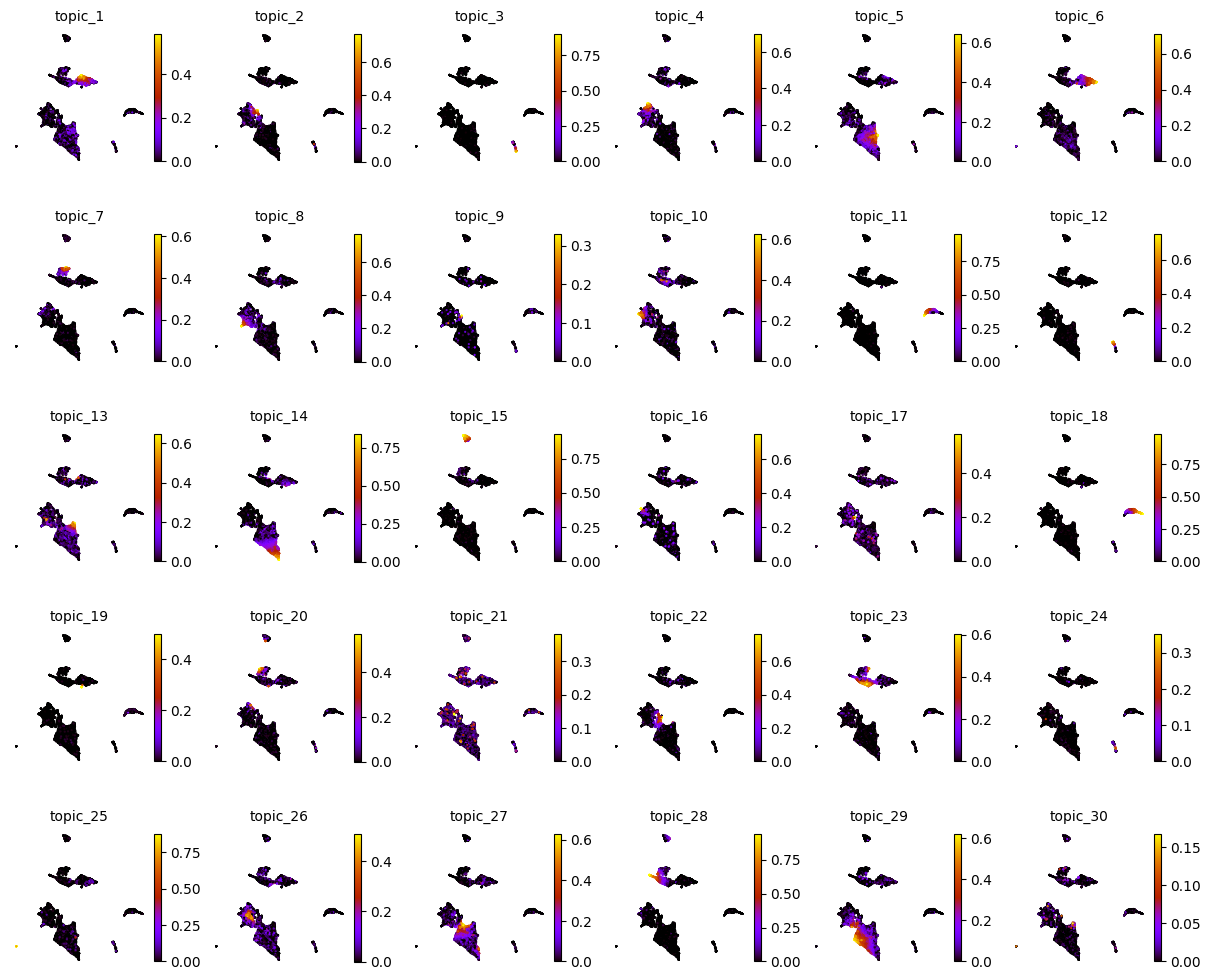

In [6]:
mtopic.pl.topics(pbmc, x='umap')

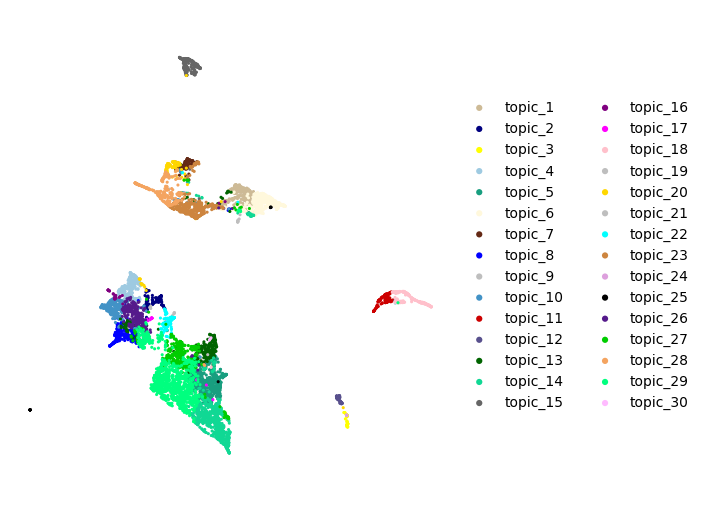

In [7]:
palette = {'topic_1': '#CDBA96', 'topic_2': '#000080', 'topic_3': '#FFFF00', 'topic_4': '#9ECAE1', 'topic_5': '#189E7F',
           'topic_6': '#FFF8DC', 'topic_7': '#642915', 'topic_8': '#0000FF', 'topic_9': '#BEBEBE', 'topic_10': '#4292C6',
           'topic_11': '#CD0000', 'topic_12': '#58508D', 'topic_13': '#006400', 'topic_14': '#10D894', 'topic_15': '#666666',
           'topic_16': '#800080', 'topic_17': '#FF00FF', 'topic_18': '#FFC0CB', 'topic_19': '#BEBEBE', 'topic_20': '#FFD700',
           'topic_21': '#BEBEBE', 'topic_22': '#00FFFF', 'topic_23': '#CD853F', 'topic_24': '#DDA0DD', 'topic_25': '#000000',
           'topic_26': '#551A8B', 'topic_27': '#00CD00', 'topic_28': '#F4A460', 'topic_29': '#00FF7F', 'topic_30': '#FFBBFF'}

mtopic.pl.dominant_topics(pbmc, x='umap', palette=palette)

To further interpret the results of the MTM, you can plot feature signatures for each modality. Feature signatures represent the importance or contribution of modality-specific features to each topic. Use `mtopic.pl.signatures` to visualize the top features per topic for any selected modality, helping to identify key markers that define each topic’s biological identity.

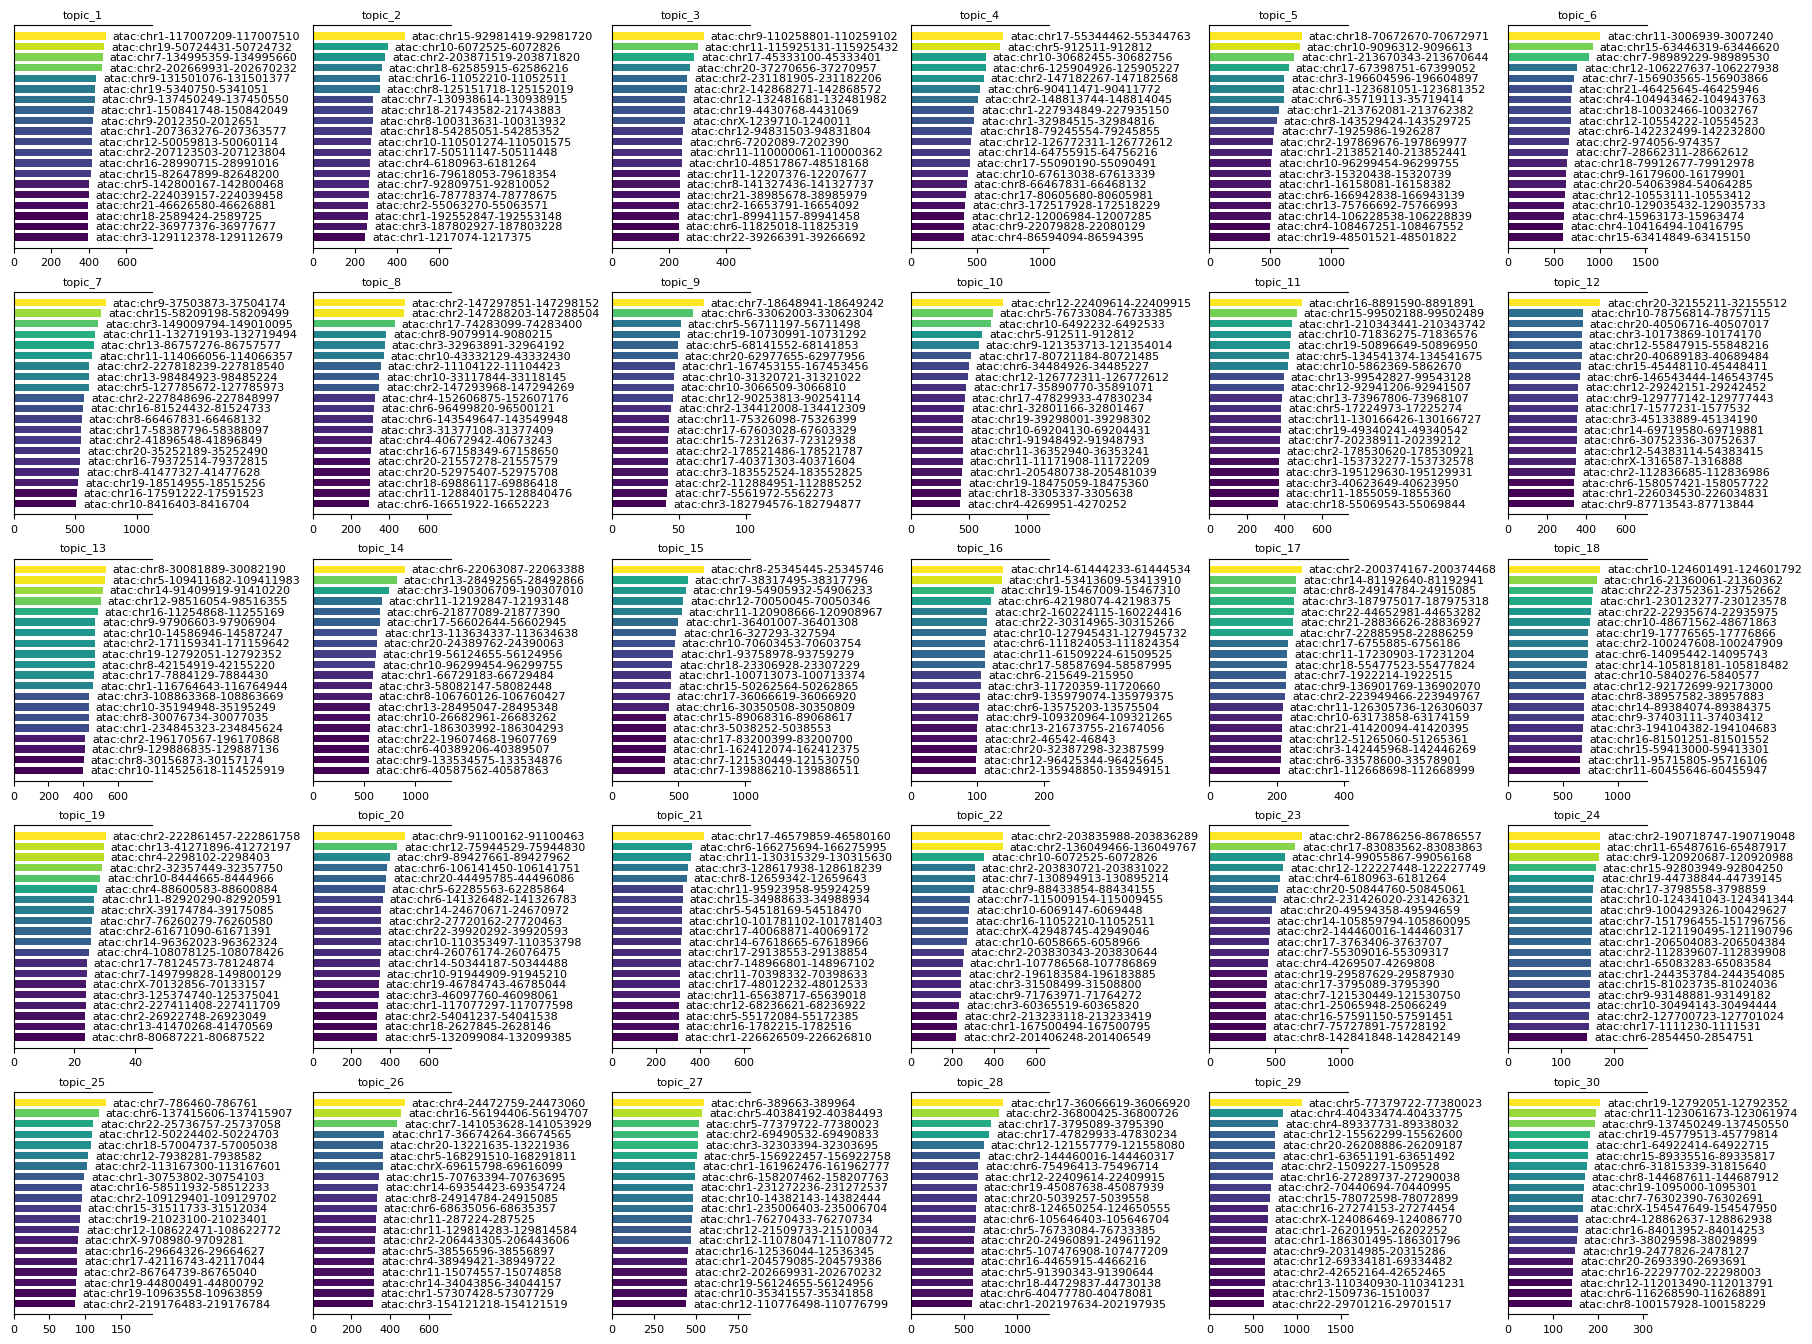

In [8]:
mtopic.pl.signatures(pbmc, mod='atac', n_top=20)

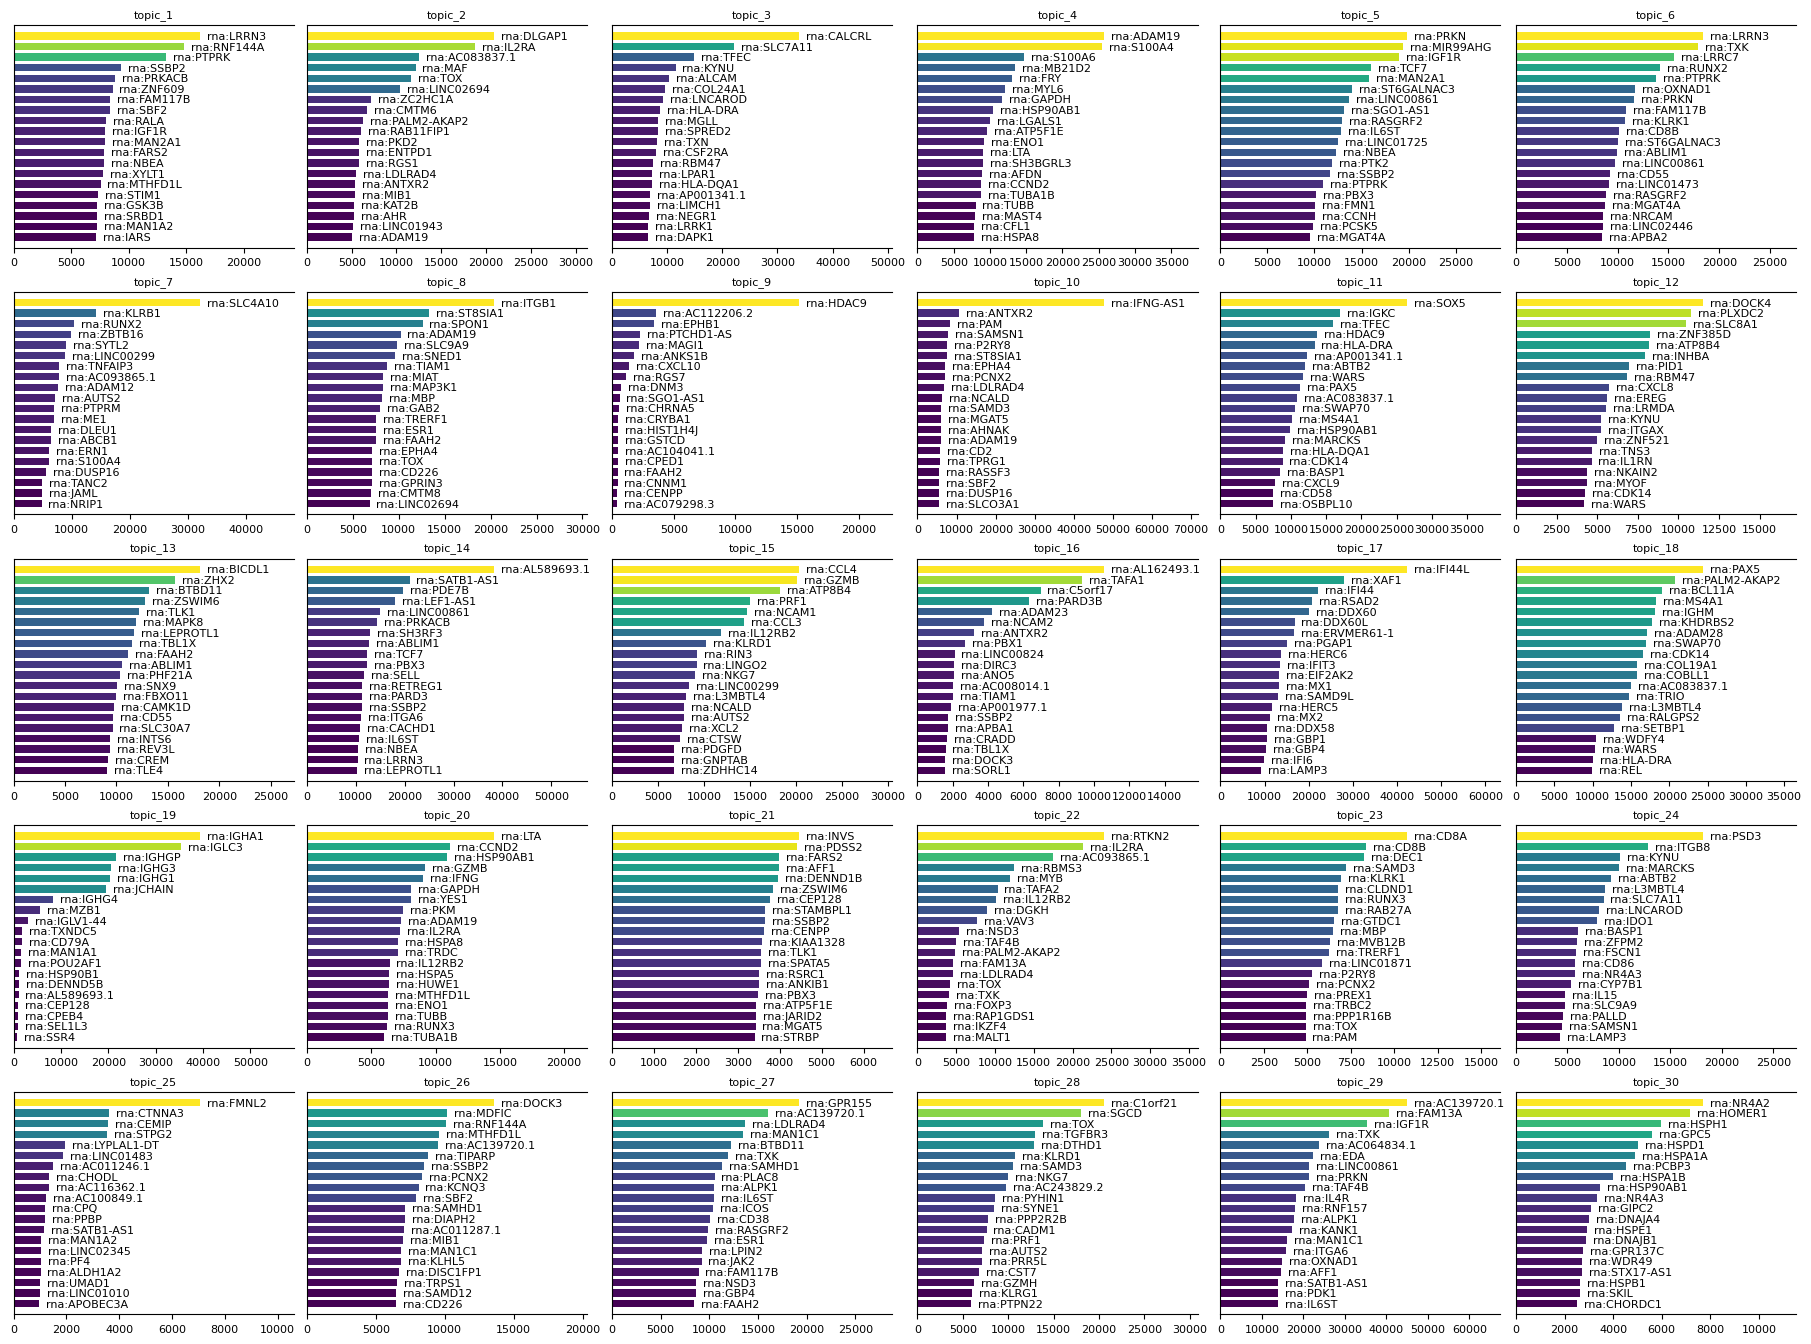

In [9]:
mtopic.pl.signatures(pbmc, mod='rna', n_top=20)

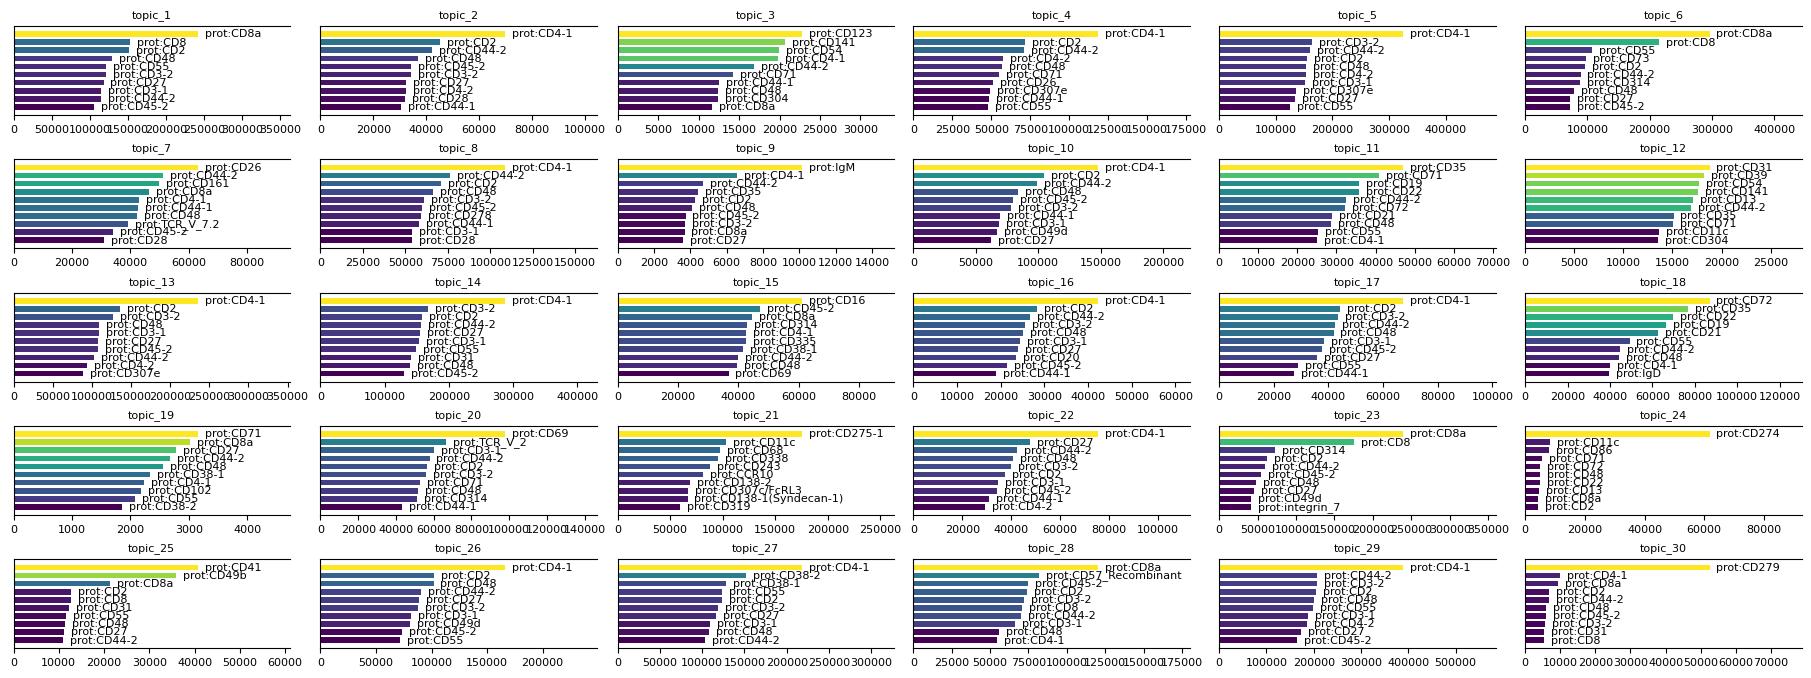

In [10]:
mtopic.pl.signatures(pbmc, mod='prot', n_top=10)

This concludes the application of `mTopic` for modeling spatial multimodal single-cell data, demonstrated using the human PBMC dataset.

In [11]:
#pbmc.write('Human_PBMC_ATAC_RNA_Protein_trained.h5mu')